# Set Up

In [1]:
# モジュールをインポート
from collections import Counter
import numpy as np
from numpy import random as rd
from scipy import stats
from scipy.stats import anderson_ksamp
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.linear_model import LinearRegression as lr
from sklearn.mixture import GaussianMixture
import warnings
import time
import pyprind
from importlib import reload

In [2]:
# DFの行と列の最大出力数を指定
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

In [3]:
# 図のフォントサイズを指定
plt.rcParams['font.size'] = 18

In [4]:
# 警告を非表示
warnings.filterwarnings('ignore')

# Method

## Preparation of Samples

### Reading File

In [5]:
# 生データ(df_raw)の読み出し
directory = '/Users/shohei/Desktop/Shohei/Fresnel/Formation'
file_name = f'{directory}/Data/dataset_new.xlsx'
sheet_name_old = '2018-10-31'
sheet_name = '2019-01-30'
excel_book = pd.ExcelFile(file_name)
#df_old = excel_book.parse(sheet_name_old)
df_raw = excel_book.parse(sheet_name)

### Linear Conversion

#### Host-star Metallicity

In [6]:
class MetalConversion:
    
    def __init__(self, df):
        # 初期設定
        self.df = df.set_index(['star', 'planet'])
        self.train = self.df.dropna(subset=['Fe/H_sweet', 'Fe/H_casa'])
        self.test = self.df[(self.df['Fe/H_sweet'].isnull())&(~self.df['Fe/H_casa'].isnull())]
        self.mod = lr()
        
    def _fit(self):
        # 線形回帰直線を求める
        self.mod.fit(self.train[['Fe/H_casa']], self.train['Fe/H_sweet'])
    
    def _predict(self):
        # 線形変換を行う
        return self.mod.predict(self.test[['Fe/H_casa']])
    
    def extract(self):
        # 線形変換を行った値を含めたカラムを作成
        df = self.df
        self._fit()
        df['Fe/H'] = df['Fe/H_sweet']
        df['Fe/H'].loc[(df['Fe/H'].isnull())&(~df['Fe/H_casa'].isnull())] = self._predict()
        return df.reset_index()
    
    def plot(self):
        # 線形変換の様子を図示
        x = self.train['Fe/H_casa']
        y = self.train['Fe/H_sweet']
        self._fit()
        a = round(self.mod.coef_[0], 3)
        b = round(self.mod.intercept_, 3)
        X = np.array([-0.9, 0.6])
        f = a*X+b
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(x, y, c='r', s=20)
        plt.plot(X, f, c='k')
        plt.xlabel('Host-star Metallicity $[Fe/H]_{Geneva-Copenhagen}$ (dex)')
        plt.ylabel('Host-star Metallicity $[Fe/H]_{SWEET-Cat}$ (dex)')
        plt.xlim(-0.9, 0.6)
        plt.ylim(-0.9, 0.6)
        plt.text(-0.75, 0.15, f'y={a}x{b}')
        fig.tight_layout()
        #fig.savefig(f'{directory}/Figure/lr_metal.pdf')
        fig.show()

In [7]:
# 主星金属量の不足データを線形変換
df_raw = MetalConversion(df_raw).extract()
#MetalConversion(df_raw).plot()

#### Host-star Mass

In [8]:
class MassConversion:
    
    def __init__(self, df):
        # 初期設定
        self.df = df.set_index(['star', 'planet'])
        self.train = self.df.dropna(subset=['Ms_sweet', 'Ms_padova'])
        self.test = self.df[(self.df['Ms_sweet'].isnull())&(~self.df['Ms_padova'].isnull())]
        self.mod = lr()
        
    def _fit(self):
        # 線形回帰直線を求める
        self.mod.fit(self.train[['Ms_padova']], self.train['Ms_sweet'])
    
    def _predict(self):
        # 線形変換を行う
        return self.mod.predict(self.test[['Ms_padova']])
    
    def extract(self):
        # 線形変換を行った値を含めたカラムを作成
        df = self.df
        self._fit()
        df['Ms'] = df['Ms_sweet']
        df['Ms'].loc[(df['Ms'].isnull())&(~df['Ms_padova'].isnull())] = self._predict()
        return df.reset_index()
    
    def plot(self):
        # 線形変換の様子を図示
        x = self.train['Ms_padova']
        y = self.train['Ms_sweet']
        self._fit()
        a = round(self.mod.coef_[0], 3)
        b = round(self.mod.intercept_, 3)
        X = np.array([0.5, 1.7])
        f = a*X+b
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(x, y, c='r', s=20)
        plt.plot(X, f, c='k')
        plt.xlabel('Host-star Mass $M_{*,Padova}$ ($M_{\odot}$)')
        plt.ylabel('Host-star Mass $M_{*,SWEET-Cat}$ ($M_{\odot}$)')
        plt.xlim(0.53, 1.67)
        plt.ylim(0.53, 1.67)
        plt.text(0.7, 1.3, f'y={a}x+{b}')
        fig.tight_layout()
        #fig.savefig(f'{directory}/Figure/lr_Ms.pdf')
        fig.show()

In [9]:
# 主星質量の不足データを線形変換
df_raw = MassConversion(df_raw).extract()
#MassConversion(df_raw).plot()

#### Plot

In [10]:
class LinearConversion:
    
    def __init__(self, df):
        df_m = df.dropna(subset=['Fe/H_sweet', 'Fe/H_casa', 'Ms'], how='any')[['Fe/H_sweet', 'Fe/H_casa', 'Ms']]
        df_M = df.dropna(subset=['Ms_sweet', 'Ms_padova', 'Ms'], how='any')[['Ms_sweet', 'Ms_padova', 'Ms']]
        self._hm = df_m[df_m['Ms']>=1.3]
        self._lm = df_m[(df_m['Ms']>=0.8)&(df_m['Ms']<1.3)]
        self._M = df_M
    
    def _add_data(self):
        casa = pd.read_csv(f'{directory}/Data/vizier_votable.tsv', sep=';')[['star', 'Fe/H_c', 'Ms_p']]
        casa['star'] = casa['star'].str.strip()
        casa = casa.set_index('star')
        file_name = f'{directory}/Data/early_star.xlsx'
        harps = pd.ExcelFile(file_name).parse('HARPS').set_index('star')
        collarie = pd.ExcelFile(file_name).parse('Collarie').set_index('star')
        merge = pd.concat([harps, collarie])
        merge = pd.concat([merge, casa], axis=1, join_axes=[merge.index]).reset_index(drop=True).astype(float)
        return merge.dropna(subset=['Fe/H_sweet', 'Fe/H_c'], how='any').rename(columns={'Fe/H_c': 'Fe/H_casa', 'Ms_p': 'Ms_padova'})
    
    def plot(self):
        df_add = self._add_data()
        Xml = self._lm[['Fe/H_casa']]
        yml = self._lm['Fe/H_sweet']
        Xmh = pd.concat([self._hm[['Fe/H_casa']], df_add[['Fe/H_casa']]])
        ymh = pd.concat([self._hm['Fe/H_sweet'], df_add['Fe/H_sweet']])
        XM = self._M[['Ms_padova']]
        yM = self._M['Ms_sweet']
        modml = lr().fit(Xml, yml)
        modmh = lr().fit(Xmh, ymh)
        modM = lr().fit(XM, yM)
        aml = round(modml.coef_[0], 3)
        bml = round(modml.intercept_, 3)
        amh = round(modmh.coef_[0], 3)
        bmh = round(modmh.intercept_, 3)
        aM = round(modM.coef_[0], 3)
        bM = round(modM.intercept_, 3)
        xm = np.array([-1, 1])
        xM = np.array([0.5, 1.7])
        fml = aml*xm+bml
        fmh = amh*xm+bmh
        fM = aM*xM+bM
        fig = plt.figure(figsize=(14, 7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.scatter(Xml, yml, c='b', s=7, label='G-type Stars')
        ax1.scatter(Xmh, ymh, c='r', s=7, label='Early-type Stars')
        ax1.plot(xm, fml, c='b')
        ax1.plot(xm, fmh, c='r')
        ax1.legend(loc='best')
        ax1.set_xlabel('Host-star Metallicity $[Fe/H]_{Geneva-Copenhagen}$ (dex)')
        ax1.set_ylabel('Host-star Metallicity $[Fe/H]_{SWEET-Cat}$ (dex)')
        ax1.set_xlim(-0.9, 0.8)
        ax1.set_ylim(-0.9, 0.8)
        ax1.text(-0.1, -0.4, f'y={aml}x+{bml}', color='b')
        ax1.text(-0.85, 0.1, f'y={amh}x+{bmh}', color='r')
        ax2.scatter(XM, yM, c='k', s=7)
        ax2.plot(xM, fM, c='k')
        ax2.set_xlabel('Host-star Mass $M_{*,Padova}$ ($M_{\odot}$)')
        ax2.set_ylabel('Host-star Mass $M_{*,SWEET-Cat}$ ($M_{\odot}$)')
        ax2.set_xlim(0.5, 1.7)
        ax2.set_ylim(0.5, 1.7)
        ax2.text(0.7, 1.45, f'y={aM}x+{bM}', color='k')
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.25)
        #fig.savefig(f'{directory}/Manuscript/Draft/linear.pdf')
        fig.show()
        print(len(Xml), len(Xmh), len(XM))

211 60 239


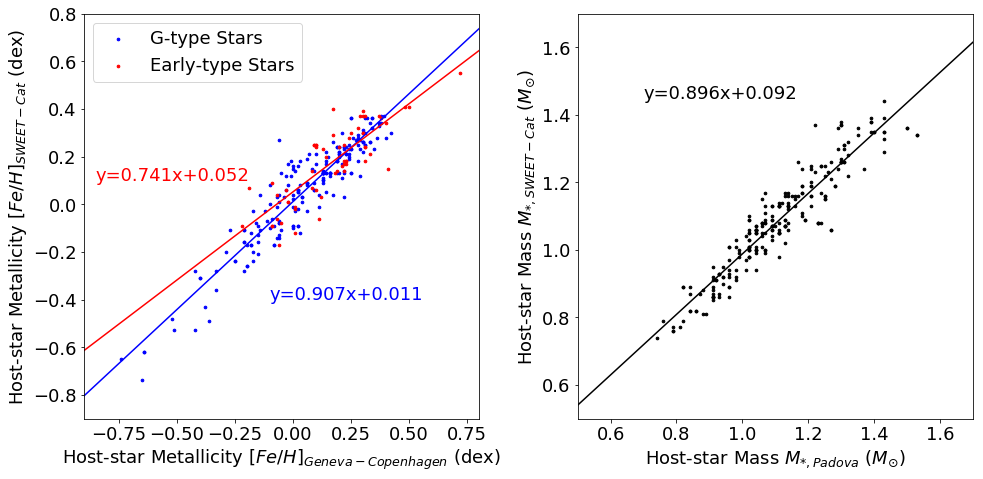

In [11]:
LinearConversion(df_raw).plot()

## Boundary between Gas Giants and Neptune-like Planets

In [10]:
class TargetData:
    
    def __init__(self, df):
        # 初期設定
        self.df = df
        
    def _drop(self, df):
        # 欠損データの除去
        cols = ['planet parameters']
        return df.dropna(subset=cols)
    
    def _select(self, df):
        # 必要なカラムを取得
        cols = ['star', 'planet', 'Fe/H', 'dFe/H', 'Ms', 'dMs', 'Mp', 'dMp', 'a', 'da', 'e', 'de', 'Term', 'RMS']
        return df[cols]
    
    def _set(self, df):
        # インデックスを設定
        return df.set_index(['star', 'planet']).astype(float)
    
    def _count(self, df):
        # 惑星系と惑星の個数を計算
        star = ''
        N = []
        n = 1
        j = 0
        length = len(df)
        index = df.index.values
        for i in range(length):
            star_i = index[i][0]
            if star_i==star:
                n += 1
            elif j!=0:
                N = np.hstack([N, [n]*n])
                n = 1
                j = 0
            if i==length-1:
                N = np.hstack([N, [n]*n])
            star = star_i
            j += 1
        df['N'] = N.astype(int)
        return df
    
    def _add(self, df):
        # 検出限界を設定
        df['a_lim'] = df['Term']**(2/3)*df['Ms']**(1/3)
        df['Mp_lim'] = 0.004919*df['RMS']*(1-df['e']**2)**(1/2)*df['Ms']**(2/3)*(df['Term']*365)**(1/3)
        return df
    
    def _divide(self, df):
        # 0.3木星質量以上の惑星を取得
        return df[df['Mp']>=0.3]
    
    def extract(self):
        # 前処理
        df = self.df
        df = self._drop(df)
        df = self._select(df)
        df = self._set(df)
        df = self._count(df)
        df = self._add(df)
        df = self._divide(df)
        return df
    
    def check(self, df):
        # データのプロパティー
        N_systems = len(df.groupby('star').sum())
        N_planets = len(df)
        print(f'Number of systems: {N_systems} samples')
        print(f'Number of planets: {N_planets} samples')
        print('\nNumber of null:')
        return df.isnull().sum()

In [11]:
# ターゲットデータ(df_tar)を作成
tar = TargetData(df_raw)
df_tar = tar.extract()

In [12]:
# 惑星系と惑星の数、および各パラメータの欠損値の数を表示
tar.check(df_tar)

Number of systems: 485 samples
Number of planets: 569 samples

Number of null:


Fe/H       0
dFe/H      0
Ms         0
dMs        0
Mp         0
dMp        0
a          0
da         0
e          0
de         0
Term      10
RMS       16
N          0
a_lim     10
Mp_lim    17
dtype: int64

## Common-biased Samples

### Procedure

In [13]:
class SelectionEffect:
    
    def __init__(self, df, metal_border, xmin=-2, xmax=1, ymin=-2, ymax=2):
        self.df_rich = df[df['Fe/H']>=metal_border]
        self.df_poor = df[df['Fe/H']<metal_border]
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
    def grid(self, df):
        xlen, ylen = 101, 101
        x_grid, y_grid = np.linspace(self.xmin, self.xmax, xlen), np.linspace(self.ymin, self.ymax, ylen)
        a_lim = np.log10(df['a_lim'].values)
        Mp_lim = np.log10(df['Mp_lim'].values)
        B = np.zeros((ylen, xlen))
        for n in range(len(df)):
            B_i = np.zeros(B.shape)
            for i in range(ylen):
                for j in range(xlen):
                    if y_grid[i]-Mp_lim[n]>=(x_grid[j]-a_lim[n])*0.5 and x_grid[j]<=a_lim[n]:
                        B_i[-i-1, j] = 1
            B += B_i
        B /= len(df)
        return pd.DataFrame(B)

In [15]:
class HeatMap:
    
    
    def __init__(self, df, metal_G=0.17, metal_E=-0.24):
        
        # 初期化
        self.all = df
        self.G = df[(df['Ms']>=0.8)&(df['Ms']<1.3)]
        self.E = df[df['Ms']>=1.3]
        self.Ar = df[df['Fe/H']>=0]
        self.Ap = df[df['Fe/H']<0]
        self.Gr = self.G[self.G['Fe/H']>=metal_G]
        self.Gp = self.G[self.G['Fe/H']<metal_G]
        self.Er = self.E[self.E['Fe/H']>=metal_E]
        self.Ep = self.E[self.E['Fe/H']<metal_E]
        self.bord_G = metal_G
        self.bord_E = metal_E
        self.x = np.linspace(0, 100, 101)
        self.y = np.linspace(100, 0, 101)
        self.a = np.linspace(-2, 2, 101).round(2)
        self.Mp = np.linspace(-2, 3, 101).round(2)
        
        
    def _convert(self, a, Mp):
        
        # データの値を変換
        a_con = [self.x[np.where(np.abs(a_i-self.a).round(3)==np.abs(a_i-self.a).min().round(3))[0][0]] for a_i in a]
        Mp_con = [self.y[np.where(np.abs(Mp_i-self.Mp).round(3)==np.abs(Mp_i-self.Mp).min().round(3))[0][0]] for Mp_i in Mp]
        return a_con, Mp_con
    
        
    def plot_one(self):
        
        # 検出確率分布の作成
        sel = SelectionEffect(self.all, 0, xmin=-2, xmax=2, ymin=-2, ymax=3)
        bias_rich = sel.grid(sel.df_rich)
        bias_poor = sel.grid(sel.df_poor)
        bias = [bias_rich, bias_poor]
        
        # 観測データの取得
        Ara = np.log10(self.Ar['a'])
        Apa = np.log10(self.Ap['a'])
        ArMp = np.log10(self.Ar['Mp'])
        ApMp = np.log10(self.Ap['Mp'])
        
        # 対数スケールに変換
        Ara_con, ArMp_con = self._convert(Ara, ArMp)
        Apa_con, ApMp_con = self._convert(Apa, ApMp)
        a = [Apa_con, Ara_con]
        Mp = [ApMp_con, ArMp_con]
        
        # 軸の表示の調整
        xbefore = np.array([1, 2, 3, 4])*100/4
        ybefore = np.array([5, 4, 3, 2, 1, 0])*100/5
        xafter = ['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$']
        yafter = ['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$']
        
        # 図の作成
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
        cbar_ax = fig.add_axes([0.88, 0.17, 0.03, 0.73])
        labels = ['Metal poor', 'Metal rich']
        for k, b in enumerate(bias):
            sns.heatmap(b,
                        ax=axes.flat[k],
                        linecolor='k',
                        linewidth=0,
                        vmin=0, vmax=1,
                        center=0.5,
                        cbar=k==0,
                        cbar_ax=None if k else cbar_ax,
                        cbar_kws={'label': 'Probability'}
                       )
            plt.sca(axes.flat[k])
            plt.xticks(xbefore, xafter, rotation=0)
            plt.yticks(ybefore, yafter, rotation=0)
            [plt.vlines(x, 0, 100, linestyles='dashed', linewidth=0.5) for x in xbefore]
            [plt.hlines(y, 0, 100, linestyles='dashed', linewidth=0.5) for y in ybefore]
            axes.flat[k].scatter(a[k], Mp[k], s=20, c='g', label=labels[k])
            axes.flat[k].legend(loc='lower right')
        axes[0].set_title('Metal rich')
        axes[0].set_xlabel('Semi-Major Axis (au)')
        axes[0].set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        axes[0].set_xlim(0, 80)
        axes[0].set_ylim(90, 10)
        axes[1].set_title('Metal poor')
        axes[1].tick_params(labelleft=False)
        axes[1].set_xlabel('Semi-Major Axis (au)')
        fig.tight_layout(rect=[0, 0, .9, 1])
        fig.subplots_adjust(wspace=0)
        #fig.savefig(f'{directory}/Figure/bias_one.png')
        fig.show()
        
        
    def plot_sep(self):
        
        # 検出確率分布の作成
        sel_G = SelectionEffect(self.G, self.bord_G)
        sel_E = SelectionEffect(self.E, self.bord_E)
        bias_G_rich = sel_G.grid(sel_G.df_rich)
        bias_G_poor = sel_G.grid(sel_G.df_poor)
        bias_E_rich = sel_E.grid(sel_E.df_rich)
        bias_E_poor = sel_E.grid(sel_E.df_poor)
        bias = [bias_G_rich, bias_G_poor, bias_E_rich, bias_E_poor]
        
        # 観測データの取得
        Gra = np.log10(self.Gr['a'])
        Gpa = np.log10(self.Gp['a'])
        Era = np.log10(self.Er['a'])
        Epa = np.log10(self.Ep['a'])
        GrMp = np.log10(self.Gr['Mp'])
        GpMp = np.log10(self.Gp['Mp'])
        ErMp = np.log10(self.Er['Mp'])
        EpMp = np.log10(self.Ep['Mp'])
        
        # 対数スケールに変換
        Gra_con, GrMp_con = self._convert(Gra, GrMp)
        Gpa_con, GpMp_con = self._convert(Gpa, GpMp)
        Era_con, ErMp_con = self._convert(Era, ErMp)
        Epa_con, EpMp_con = self._convert(Epa, EpMp)
        a = [Gpa_con, Gra_con, Epa_con, Era_con]
        Mp = [GpMp_con, GrMp_con, EpMp_con, ErMp_con]
        
        # 軸の表示の調整
        xbefore = np.array([1, 2, 3])*100/4
        ybefore = np.array([4, 3, 2, 1])*100/5
        xafter = ['$10^{-1}$', '$10^{0}$', '$10^{1}$']
        yafter = ['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$']
        
        # 図の作成
        fig, axes = plt.subplots(2, 2, figsize=(12, 11), sharex=True, sharey=True)
        cbar_ax = fig.add_axes([0.88, 0.17, 0.03, 0.73])
        labels = ['Metal poor', 'Metal rich', 'Metal poor', 'Metal rich']
        for k, b in enumerate(bias):
            sns.heatmap(b,
                        ax=axes.flat[k],
                        linecolor='k',
                        linewidth=0,
                        vmin=0, vmax=1,
                        center=0.5,
                        cbar=k==0,
                        cbar_ax=None if k else cbar_ax,
                        cbar_kws={'label': 'Probability'}
                       )
            plt.sca(axes.flat[k])
            plt.xticks(xbefore, xafter, rotation=0)
            plt.yticks(ybefore, yafter, rotation=0)
            [plt.vlines(x, 0, 100, linestyles='dashed', linewidth=0.5) for x in xbefore]
            [plt.hlines(y, 0, 100, linestyles='dashed', linewidth=0.5) for y in ybefore]
            #axes.flat[k].scatter(a[k], Mp[k], s=20, c='g', label=labels[k])
            #axes.flat[k].legend(loc='lower right')
        axes[0, 0].set_title('Metal rich')
        axes[0, 0].tick_params(labelbottom=False)
        axes[0, 0].set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        axes[0, 1].set_title('Metal poor')
        axes[0, 1].tick_params(labelleft=False, labelbottom=False)
        axes[0, 1].text(-23, 7, 'G-type Stars', fontsize=22, bbox=dict(facecolor='gold'))
        axes[1, 0].set_xlabel('Semi-Major Axis (au)')
        axes[1, 0].set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        axes[1, 1].set_xlabel('Semi-Major Axis (au)')
        axes[1, 1].tick_params(labelleft=False)
        axes[1, 1].text(-28, 7, 'Early-type Stars', fontsize=22, bbox=dict(facecolor='gold'))
        fig.tight_layout(rect=[0, 0, .9, 1])
        fig.subplots_adjust(hspace=0, wspace=0)
        #fig.savefig(f'{directory}/Figure/bias_sep.png')
        fig.savefig(f'{directory}/Figure/bias_sep_no.png')
        fig.show()

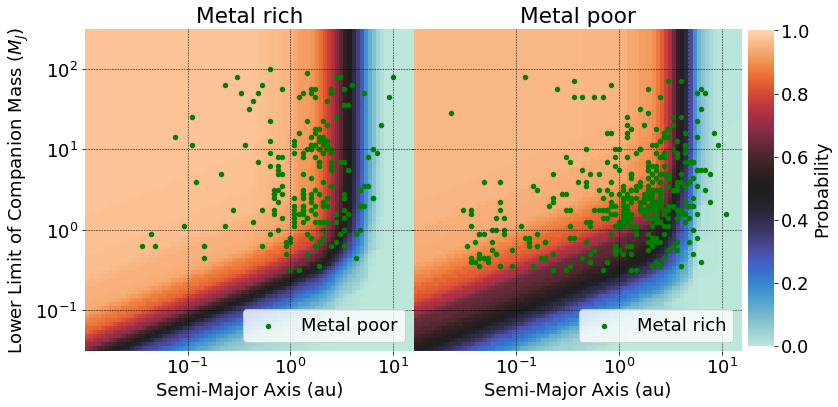

In [24]:
# 全主星周りの検出確率分布上に観測データをプロット
HeatMap(df_tar).plot_one()

### Making

In [30]:
class CommonBiasedSample:
    
    def __init__(self, df, metal_G=None, metal_E=None):
        #初期化
        _df = self._set(df)
        self.df = _df
        if metal_G:
            self.G = _df[(_df['Ms']>=0.8)&(_df['Ms']<1.3)]
            self.Gr = self.G[self.G['Fe/H']>=metal_G]
            self.Gp = self.G[self.G['Fe/H']<metal_G]
            self.metal_G = metal_G
        if metal_E:
            self.E = _df[_df['Ms']>=1.3]
            self.Er = self.E[self.E['Fe/H']>=metal_E]
            self.Ep = self.E[self.E['Fe/H']<metal_E]
            self.metal_E = metal_E
        self.a = np.linspace(-2, 1, 101).round(2)
        self.Mp = np.linspace(-2, 2, 101).round(2)
           
    def _set(self, df):
        # 各パラメータの値を正規分布に従って計算
        metal = rd.normal(df['Fe/H'], df['dFe/H'])
        Ms = rd.normal(df['Ms'], df['dMs'])
        Mp = rd.normal(df['Mp'], df['dMp'])
        a = rd.normal(df['a'], df['da'])
        e = rd.normal(df['e'], df['de'])
        Ms = np.where(Ms<0, 0.001, Ms)
        Mp = np.where(Mp<0, 0.001, Mp)
        a = np.where(a<0, 0.001, a)
        e = np.where(e<0, 0, e)
        e = np.where(e>1, 1, e)
        return pd.DataFrame({'Fe/H': metal, 'dFe/H': df['dFe/H'],
                             'Ms': Ms, 'dMs': df['dMs'],
                             'Mp': Mp, 'dMp': df['dMp'],
                             'a': a, 'da': df['da'],
                             'e': e, 'de': df['de'],
                             'RMS': df['RMS'], 'Term': df['Term']
                            }, index=df.index)
          
    def _limit(self, df):
        # 検出限界を計算
        df['a_lim'] = df['Term']**(2/3)*df['Ms']**(1/3)
        df['Mp_lim'] = 0.004919*df['RMS']*(1-df['e']**2)**(1/2)*df['Ms']**(2/3)*(df['Term']*365)**(1/3)
        return df
           
    def _probability(self, df, metal, metal_border):
        # 検出確率分布を作成
        df = self._limit(df)
        se = SelectionEffect(df, metal_border)
        if metal=='rich':
            f = se.grid(se.df_poor)
        elif metal=='poor':
            f = se.grid(se.df_rich)
        f.index = self.Mp[::-1]
        f.columns = self.a
        return f
    
    def extract(self, star_type, metal):
        # 各領域のCommon-biased sampleを作成
        if star_type=='G':
            f = self._probability(self.G, metal, self.metal_G)
            if metal=='rich':
                os = self.Gr
            elif metal=='poor':
                os = self.Gp
        elif star_type=='E':
            f = self._probability(self.E, metal, self.metal_E)
            if metal=='rich':
                os = self.Er
            elif metal=='poor':
                os = self.Ep
        #print(f'Original {star_type}({metal}):', len(os))
        os = os.reset_index()
        planets = os['planet'].values
        a_all = np.log10(os['a'].values)
        Mp_all = np.log10(os['Mp'].values)
        for planet, a, Mp in zip(planets, a_all, Mp_all):
            num_a = self.a[np.where(np.abs(self.a-a).round(3)==np.abs(self.a-a).min().round(3))][0]
            num_Mp = self.Mp[np.where(np.abs(self.Mp-Mp).round(3)==np.abs(self.Mp-Mp).min().round(3))][0]
            judge = rd.binomial(1, f[num_a][num_Mp], 1)[0]
            if judge==0:
                os = os[os['planet']!=planet]
        #print(f'Common-biased {star_type}({metal}):', len(os))
        return os.set_index(['star', 'planet'])

In [31]:
# Common-biased sampleの作成
def making(df):
    cbs = CommonBiasedSample(df, metal_G=0.17, metal_E=-0.24)
    Gr = cbs.extract(star_type='G', metal='rich')
    Gp = cbs.extract(star_type='G', metal='poor')
    Er = cbs.extract(star_type='E', metal='rich')
    Ep = cbs.extract(star_type='E', metal='poor')
    return pd.concat([Gr, Gp, Er, Ep])

df_pred = making(df_tar)

In [32]:
# 惑星サンプルの数の変移を計算
def discount(df, n_iter=10):
    NtG = len(df[(df['Ms']>=0.8)&(df['Ms']<1.3)])
    NtE = len(df[df['Ms']>=1.3])
    NpG, NpE = [], []
    pbar = pyprind.ProgBar(n_iter)
    for _ in range(n_iter):
        df_pred = making(df)
        NpG.append(len(df_pred[(df_pred['Ms']>=0.8)&(df_pred['Ms']<1.3)]))
        NpE.append(len(df_pred[df_pred['Ms']>=1.3]))
        pbar.update()
    NpG = np.mean(NpG)
    NpE = np.mean(NpE)
    print('G-type')
    print('Before:', NtG, ', After:', int(NpG), ', ', round(NpG/NtG, 2)*100, '%')
    print('Early-type')
    print('Before:', NtE, ', After:', int(NpE), ', ', round(NpE/NtE, 2)*100, '%')
    
discount(df_tar, n_iter=100)

0% [##############################] 100% | ETA: 00:00:00

G-type
Before: 340 , After: 239 ,  70.0 %
Early-type
Before: 188 , After: 129 ,  69.0 %



Total time elapsed: 00:07:31


### Metallicity Boundary for Common-biased Samples

In [35]:
class MetallicityBoundary:
    
    def __init__(self, df):
        # 初期設定
        self.all = df
        self.G = df[(df['Ms']>=0.8)&(df['Ms']<1.3)]
        self.E = df[df['Ms']>=1.3]
        self.bord = np.linspace(-0.6, 0.3, 41)
       
    def _AD(self, X1, X2):
        # AD検定を行いp値を計算
        ad = anderson_ksamp([X1, X2])
        return ad.significance_level
    
    def _iterate(self, df):
        # AD検定を繰り返し計算
        pm = []
        pe = []
        pbar = pyprind.ProgBar(len(self.bord))
        for bord in self.bord:
            if self.type=='G':
                metal_G = bord
                metal_E = None
            elif self.type=='E':
                metal_G = None
                metal_E = bord
            p = []
            for _ in range(self.n):
                cbs = CommonBiasedSample(self.all, metal_G=metal_G, metal_E=metal_E)
                df_rich = cbs.extract(star_type=self.type, metal='rich')
                df_poor = cbs.extract(star_type=self.type, metal='poor')
                X1 = df_rich[self.param].values
                X2 = df_poor[self.param].values
                p.append(self._AD(X1, X2))
            pm.append(np.mean(p))
            pe.append(np.std(p))
            pbar.update()
        return pm, pe
    
    def extract(self, star_type, param, n_iter=1000):
        # _AD関数を行いp値を取得
        self.type = star_type
        self.param = param
        self.n = n_iter
        if star_type=='all':
            return self._iterate(self.all)
        elif star_type=='G':
            return self._iterate(self.G)
        elif star_type=='E':
            return self._iterate(self.E)
        
    def best(self, pm):
        return self.bord[np.where(pm==np.min(pm))][0]
        
    def save(self, pm, pe, star_type, param):
        np.save(f'{directory}/Result/pm{star_type}{param}.npy', pm)
        np.save(f'{directory}/Result/pe{star_type}{param}.npy', pe)        
        
    def plot(self, ax, p, pe, title=None, xlabel=False, ylabel=False):
        # 境界金属量とp値のグラフを図示
        ax.plot(self.bord, p, '--bo', color='r', markersize=5)
        ax.errorbar(self.bord, p, yerr=pe, fmt='o', ecolor='k', ms=0, elinewidth=1, capsize=4, capthick=1)
        ax.grid(which='major', linestyle='dashed')
        ax.set_yscale('log')
        if title: ax.set_title(title)
        if xlabel: ax.set_xlabel('Boundary of Metallicity [Fe/H] (dex)')
        if ylabel: ax.set_ylabel('p value')

In [36]:
mb = MetallicityBoundary(df_tar)

In [39]:
# 惑星質量の分布に対しAD検定を行い、p値を取得
pmgMp, pegMp = mb.extract(star_type='G', param='Mp', n_iter=100)
pmeMp, peeMp = mb.extract(star_type='E', param='Mp', n_iter=100)
#mb.save(pmgMp, pegMp, 'g', 'Mp')
#mb.save(pmeMp, peeMp, 'e', 'Mp')

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 03:03:24
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 01:44:57


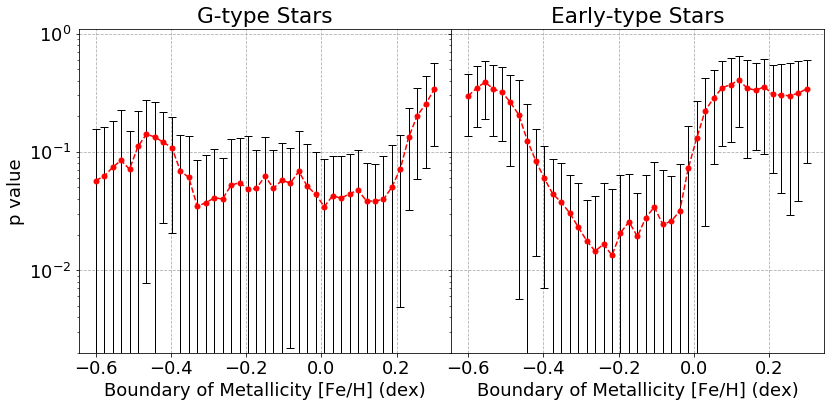

In [40]:
# 境界金属量とp値のグラフを図示
#pmgMp = np.load(f'{directory}/Result/pmgMp.npy')
#pegMp = np.load(f'{directory}/Result/pegMp.npy')
#pmeMp = np.load(f'{directory}/Result/pmeMp.npy')
#peeMp = np.load(f'{directory}/Result/peeMp.npy')
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
mb.plot(ax1, pmgMp, pegMp, title='G-type Stars', xlabel=True, ylabel=True)
mb.plot(ax2, pmeMp, peeMp, title='Early-type Stars', xlabel=True)
ax1.set_ylim(0.002, 1.1)
ax2.tick_params(labelleft=False)
fig.tight_layout()
fig.subplots_adjust(wspace=0)
#fig.savefig(f'{directory}/Figure/metal_boundary.pdf')
fig.show()

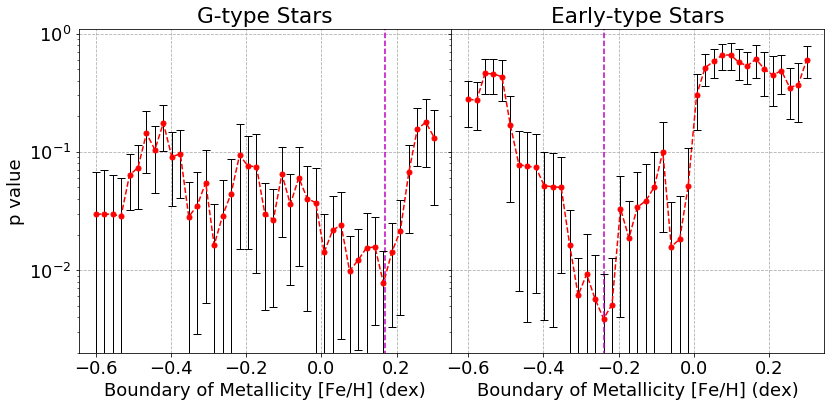

In [189]:
# 境界金属量とp値のグラフを図示
pmgMp = np.load(f'{directory}/Result/pmgMp.npy')
pegMp = np.load(f'{directory}/Result/pegMp.npy')
pmeMp = np.load(f'{directory}/Result/pmeMp.npy')
peeMp = np.load(f'{directory}/Result/peeMp.npy')
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
mb.plot(ax1, pmgMp, pegMp, title='G-type Stars', xlabel=True, ylabel=True)
mb.plot(ax2, pmeMp, peeMp, title='Early-type Stars', xlabel=True)
ax1.vlines(0.17, 0.001, 2, color='m', linestyle='dashed')
ax2.vlines(-0.24, 0.001, 2, color='m', linestyle='dashed')
ax1.set_ylim(0.002, 1.1)
ax2.tick_params(labelleft=False)
fig.tight_layout()
fig.subplots_adjust(wspace=0)
#fig.savefig(f'{directory}/Manuscript/Draft/metal_boundary.pdf')
fig.show()

In [41]:
# 最適な境界金属量の決定
metal_G = round(mb.best(pmgMp), 2)
metal_E = round(mb.best(pmeMp), 2)
pgbest = round(pmgMp[np.where(mb.bord==mb.best(pmgMp))[0][0]], 5)
pebest = round(pmeMp[np.where(mb.bord==mb.best(pmeMp))[0][0]], 5)
print('(metal boundary, pvalue)')
print(f'     G-type Stars: [Fe/H]={metal_G}, p={pgbest}')
print(f' Early-type Stars: [Fe/H]={metal_E}, p={pebest}')

(metal boundary, pvalue)
     G-type Stars: [Fe/H]=0.01, p=0.03447
 Early-type Stars: [Fe/H]=-0.22, p=0.01333


In [154]:
# 最適な境界金属量の決定
metal_G = round(mb.best(pmgMp), 2)
metal_E = round(mb.best(pmeMp), 2)
pgbest = round(pmgMp[np.where(mb.bord==mb.best(pmgMp))[0][0]], 5)
pebest = round(pmeMp[np.where(mb.bord==mb.best(pmeMp))[0][0]], 5)
print('(metal boundary, pvalue)')
print(f'     G-type Stars: [Fe/H]={metal_G}, p={pgbest}')
print(f' Early-type Stars: [Fe/H]={metal_E}, p={pebest}')

(metal boundary, pvalue)
     G-type Stars: (0.17, 0.007759699132600615)
 Early-type Stars: (-0.24, 0.003880068333191434)


### Selection Effect

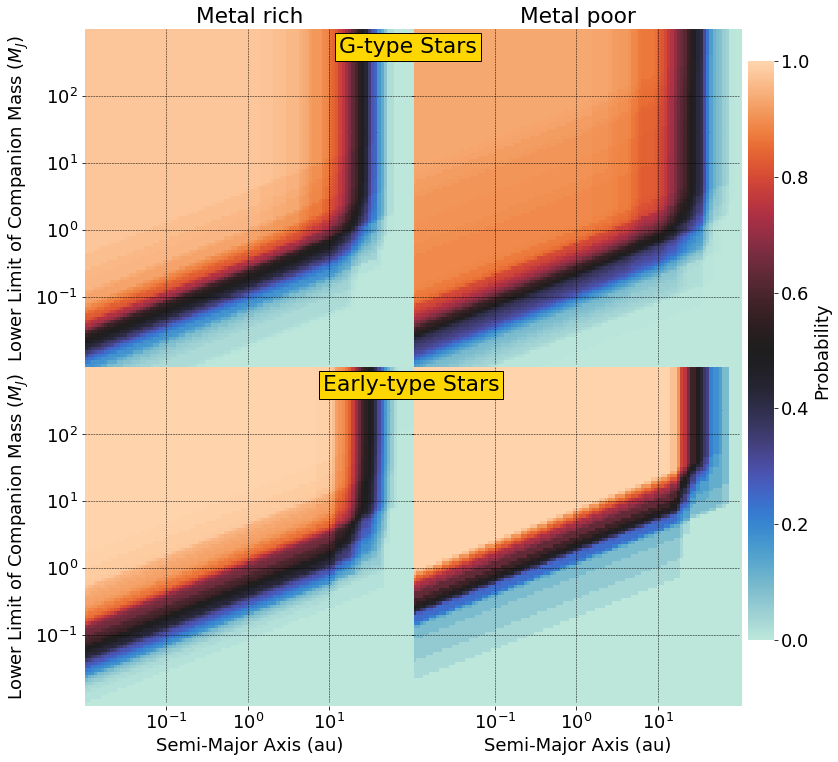

In [16]:
# G型星および早期型星の検出確率分布を図示
HeatMap(df_tar, metal_G=0.17, metal_E=-0.24).plot_sep()

# Results

## Three-Mass Regimes of Gaseous Objects

### Best Number of Cluster with Gaussian Mixture Model

In [194]:
class ClusterNumber:
    
    def __init__(self, df):
        self.df = df
        
    def _BIC(self, X, n_components=10, covariance_type='full'):
        BIC = []
        for n in range(n_components):
            gm = GaussianMixture(n_components=n+1, covariance_type=covariance_type)
            gm.fit(X)
            BIC.append(gm.bic(X))
        return BIC 
        
    def _scoring(self):
        _df = make(self.df)
        _arr = _df[['Fe/H', 'Mp']].values
        return self._BIC(_arr)
    
    def calculation(self, n_iter=10):
        return np.mean([self._scoring() for _ in range(n_iter)], axis=0)

    def plot(self, BIC):
        x = np.arange(10)+1
        y = BIC
        fig = plt.figure(figsize=(7, 5))
        plt.plot(x, y, '--bo')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Error Score')
        fig.tight_layout()
        fig.savefig(f'{directory}/Manuscript/Draft/bic.pdf')
        fig.show()

In [507]:
# BICでクラスター数の評価
BIC = ClusterNumber(df_tar).calculation()

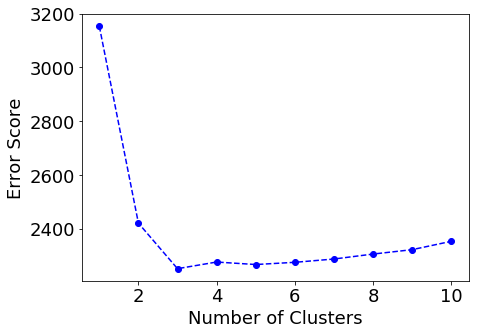

In [508]:
# BICの結果を図示
ClusterNumber(df_tar).plot(BIC)

### Labeling

In [35]:
class Labeling:
    
    def __init__(self, df, n_components=3):
        self.df = df
        self.n = n_components
        
    def _GMM(self, X, n_components=3, covariance_type='full'):
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        gmm.fit(X)
        return gmm
    
    def learning(self, N=1):
        pbar = pyprind.ProgBar(N)
        for n in range(N):
            _df = making(self.df)
            _arr = _df[['Fe/H', 'Mp']].values
            _gm = self._GMM(_arr, n_components=self.n)
            if n==0:
                _df_Label = pd.DataFrame({'L0': _gm.predict(_arr)}, index=_df.index)
            else:
                _df_label = pd.DataFrame({f'L{n}': _gm.predict(_arr)}, index=_df.index)
                _df_Label = pd.concat([_df_Label, _df_label], axis=1)
            pbar.update()
        return _df_Label.mode(axis=1)[[0]].rename(columns={0: 'label'})

In [36]:
# 最適なラベルを決定
df_label = Labeling(df_tar).learning(N=100)
df_pred = pd.concat([df_pred, df_label], axis=1, join_axes=[df_pred.index])

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:19


### Determination of Planet-mass Boundary

In [37]:
# 各領域における平均金属量と平均軌道長半径、および平均離心率の値を計算
def mean(df, param, All=False, n=100):
    if All:
        A1m, A2m, A3m = [], [], []
    G1m, G2m, G3m = [], [], []
    E1m, E2m, E3m = [], [], []
    pbar = pyprind.ProgBar(n)
    for _ in range(n):
        _df = making(df)
        df_G = _df[(_df['Ms']>=0.8)&(_df['Ms']<1.3)]
        df_E = _df[_df['Ms']>=1.3]
        if All:
            A1 = _df[_df['Mp']>=25][param]
            A2 = _df[(_df['Mp']>=4)&(_df['Mp']<25)][param]
            A3 = _df[_df['Mp']<4][param]
        G1 = df_G[df_G['Mp']>=25][param]
        G2 = df_G[(df_G['Mp']>=4)&(df_G['Mp']<25)][param]
        G3 = df_G[df_G['Mp']<4][param]
        E1 = df_E[df_E['Mp']>=25][param]
        E2 = df_E[(df_E['Mp']>=4)&(df_E['Mp']<25)][param]
        E3 = df_E[df_E['Mp']<4][param]
        if All:
            A1m.append(A1.mean())
            A2m.append(A2.mean())
            A3m.append(A3.mean())
        G1m.append(G1.mean())
        G2m.append(G2.mean())
        G3m.append(G3.mean())
        E1m.append(E1.mean())
        E2m.append(E2.mean())
        E3m.append(E3.mean())
        pbar.update()
    if All:
        Am = np.mean([A1m, A2m, A3m], axis=1)
        Ae = np.std([A1m, A2m, A3m], axis=1)
    Gm = np.mean([G1m, G2m, G3m], axis=1)
    Ge = np.std([G1m, G2m, G3m], axis=1)
    Em = np.mean([E1m, E2m, E3m], axis=1)
    Ee = np.std([E1m, E2m, E3m], axis=1)
    if All:
        return Am, Ae, Gm, Ge, Em, Ee
    else:
        return Gm, Ge, Em, Ee

Amm, Ame, Gmm, Gme, Emm, Eme = mean(df_tar, 'Fe/H', All=True, n=100)
Gam, Gae, Eam, Eae = mean(df_tar, 'a', n=100)
Gem, Gee, Eem, Eee = mean(df_tar, 'e', n=100)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:18
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:20
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:13


In [38]:
class Casagrande:
    
    def __init__(self, df):
        self._mod = lr()
        self._df = df.dropna(subset=['Ms_sweet', 'Ms_padova'])
        self._casa = pd.read_csv(f'{directory}/Data/vizier_votable.tsv', sep=';')[['Fe/H_c', 'Ms_p', 'Ms_b']]
        self._casa = self._casa.dropna().astype(float)
        self._casa = self._casa.rename(columns={'Fe/H_c': 'Fe/H'})
        self._casa['Ms'] = self._predict()
        self._low = self._casa[(self._casa['Ms']>=0.8)&(self._casa['Ms']<1.3)]
        self._high = self._casa[self._casa['Ms']>=1.3]
    
    def _predict(self):
        self._mod.fit(self._df[['Ms_padova']], self._df['Ms_sweet'])
        return self._mod.predict(self._casa[['Ms_p']])
    
    def extract(self):
        mam = self._casa['Fe/H'].mean()
        mae = self._casa['Fe/H'].std()/len(self._casa['Fe/H'])**0.5
        mlm = self._low['Fe/H'].mean()
        mle = self._low['Fe/H'].std()/len(self._low['Fe/H'])**0.5
        mhm = self._high['Fe/H'].mean()
        mhe = self._high['Fe/H'].std()/len(self._high['Fe/H'])**0.5
        return mam, mae, mlm, mle, mhm, mhe

In [39]:
# Casagrandeのデータベースより取得した星の平均金属量をそれぞれの領域で計算
Ammc, Amec, Gmmc, Gmec, Emmc, Emec = Casagrande(df_raw).extract()

In [44]:
class GMM:
    
    def __init__(self, df, mm, me, mcm, mce, mass_bord=[4, 25]):
        df = self._color(df, mass_bord)
        self.df = df
        self.bord = mass_bord
        self.mm = np.array(mm)
        self.me = np.array(me)
        self.mcm = mcm
        self.mce = mce
        
    def _color(self, df, borders):
        df['color'] = 'r'
        df['color'] = df['color'].where((df['Mp']<borders[0])|(df['Mp']>=borders[1]), 'g')
        df['color'] = df['color'].where(df['Mp']<borders[1], 'b')
        return df
        
    def _labels(self, ax):
        label = self.df['label'].unique()
        x = [self.df[self.df['label']==l]['Fe/H'].values for l in label]
        y = [self.df[self.df['label']==l]['Mp'].values for l in label]
        color = [self.df[self.df['label']==l]['color'].values for l in label]
        marker = ['o', '^', ',']
        for _x, _y, _c , _m in zip(x, y, color, marker):
            ax.scatter(_x, _y, c=_c, marker=_m, s=20)
        ax.set_yscale('log')
        [ax.hlines([bord], -1.0, 10, 'black', linestyles='dashed') for bord in self.bord]
        ax.set_xlabel('Host-star Metallicity [Fe/H] (dex)')
        ax.set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        ax.set_xlim(-1.0, 0.5)
        ax.set_ylim(0.05, 200)    
    
    def plot(self):
        ml = self.mm-self.me
        mr = self.mm+self.me
        mcl = self.mcm-self.mce
        mcr = self.mcm+self.mce
        range1 = [[ml[0], ml[0], mr[0], mr[0]], [200, 25, 25 ,200]]
        range2 = [[ml[1], ml[1], mr[1], mr[1]], [25, 4, 4, 25]]
        range3 = [[ml[2], ml[2], mr[2], mr[2]], [4, 0.05, 0.05 ,4]]
        rangec = [[mcl, mcl, mcr, mcr], [200, 0.05, 0.05 ,200]]
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        self._labels(ax)
        plt.vlines(self.mm[0], 25, 200, color='k', linestyle='dotted')
        plt.vlines(self.mm[1], 4, 25, color='k', linestyle='dotted')
        plt.vlines(self.mm[2], 0.05, 4, color='k', linestyle='dotted')
        plt.vlines(self.mcm, 0.05, 200, color='m', linestyle='dotted')
        plt.fill(range1[0], range1[1], c='k', alpha=0.3)
        plt.fill(range2[0], range2[1], c='k', alpha=0.3)
        plt.fill(range3[0], range3[1], c='k', alpha=0.3)
        plt.fill(rangec[0], rangec[1], c='m', alpha=0.3)
        plt.xlim(-0.9, 0.6)
        plt.ylim(0.2, 180)
        fig.tight_layout()
        #fig.savefig(f'{directory}/Manuscript/Draft/gmm.pdf')
        fig.show()

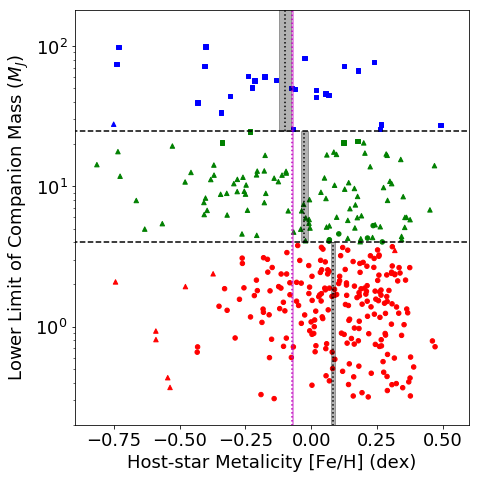

In [45]:
GMM(df_pred, Amm, Ame, Ammc, Amec).plot()

## Planetary Distribution around G- and Early-type Stars

### Metallicity vs Planet Mass Distribution

In [50]:
class MetalMass:
    
    def __init__(self, df, Gmm, Gme, Emm, Eme, Gmmc, Gmec, Emmc, Emec):
        df['color'] = df['Mp'].apply(lambda x: 'b' if x>=25 else('g' if 4<=x<25 else 'r'))
        self.df = df
        self.G = df[(df['Ms']>=0.8)&(df['Ms']<1.3)]
        self.E = df[df['Ms']>=1.3]
        self.Gmm = np.array(Gmm)
        self.Gme = np.array(Gme)
        self.Emm = np.array(Emm)
        self.Eme = np.array(Eme)
        self.Gmmc = Gmmc
        self.Gmec = Gmec
        self.Emmc = Emmc
        self.Emec = Emec
        
    def plot(self):
        mgl = self.Gmm-self.Gme
        mgr = self.Gmm+self.Gme
        mel = self.Emm-self.Eme
        mer = self.Emm+self.Eme
        mgcl = self.Gmmc-self.Gmec
        mgcr = self.Gmmc+self.Gmec
        mecl = self.Emmc-self.Emec
        mecr = self.Emmc+self.Emec
        range1l = [[mgl[0], mgl[0], mgr[0], mgr[0]], [180, 25, 25, 180]]
        range2l = [[mgl[1], mgl[1], mgr[1], mgr[1]], [25, 4, 4, 25]]
        range3l = [[mgl[2], mgl[2], mgr[2], mgr[2]], [4, 0.05, 0.05, 4]]
        range1h = [[mel[0], mel[0], mer[0], mer[0]], [180, 25, 25, 180]]
        range2h = [[mel[1], mel[1], mer[1], mer[1]], [25, 4, 4, 25]]
        range3h = [[mel[2], mel[2], mer[2], mer[2]], [4, 0.05, 0.05, 4]]
        rangel_casa = [[mgcl, mgcl, mgcr, mgcr], [180, 0.05, 0.05, 180]]
        rangeh_casa = [[mecl, mecl, mecr, mecr], [180, 0.05, 0.05, 180]]
        fig = plt.figure(figsize=(12, 7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
        ax1.scatter(self.G['Fe/H'], self.G['Mp'], c=self.G['color'], s=20)
        ax1.vlines(self.Gmm[0], 25, 180, color='k', linestyle='dashed')
        ax1.vlines(self.Gmm[1], 4, 25, color='k', linestyle='dashed')
        ax1.vlines(self.Gmm[2], 0.05, 4, color='k', linestyle='dashed')
        ax1.vlines(self.Gmmc, 0.05, 180, color='m', linestyle='dashed')
        ax1.hlines(25, -0.9, 0.6, color='k', linestyle='dashed')
        ax1.hlines(4, -0.9, 0.6, color='k', linestyle='dashed')
        ax1.fill(range1l[0], range1l[1], c='k', alpha=0.3)
        ax1.fill(range2l[0], range2l[1], c='k', alpha=0.3)
        ax1.fill(range3l[0], range3l[1], c='k', alpha=0.3)
        ax1.fill(rangel_casa[0], rangel_casa[1], c='m', alpha=0.3)
        ax1.set_yscale('log')
        ax1.set_title('G-type Stars')
        ax1.set_xlabel('Host-star Metallicity [Fe/H] (dex)')
        ax1.set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        ax1.set_xlim(-0.9, 0.6)
        ax1.set_ylim(0.2, 180)
        ax2.scatter(self.E['Fe/H'], self.E['Mp'], c=self.E['color'], s=20)
        ax2.vlines(self.Emm[0], 25, 180, color='k', linestyle='dashed')
        ax2.vlines(self.Emm[1], 4, 25, color='k', linestyle='dashed')
        ax2.vlines(self.Emm[2], 0.05, 4, color='k', linestyle='dashed')
        ax2.vlines(self.Emmc, 0.05, 180, color='m', linestyle='dashed')
        ax2.hlines(25, -0.9, 0.6, color='k', linestyle='dashed')
        ax2.hlines(4, -0.9, 0.6, color='k', linestyle='dashed')
        ax2.fill(range1h[0], range1h[1], c='k', alpha=0.3)
        ax2.fill(range2h[0], range2h[1], c='k', alpha=0.3)
        ax2.fill(range3h[0], range3h[1], c='k', alpha=0.3)
        ax2.fill(rangeh_casa[0], rangeh_casa[1], c='m', alpha=0.3)
        ax2.set_title('Early-type Stars')
        ax2.tick_params(labelleft=False)
        ax2.set_xlabel('Host-star Metallicity [Fe/H] (dex)')
        fig.tight_layout()
        fig.subplots_adjust(wspace=0)
        #fig.savefig(f'{directory}/Manuscript/Draft/metal_Mp_sep.pdf')
        fig.show()

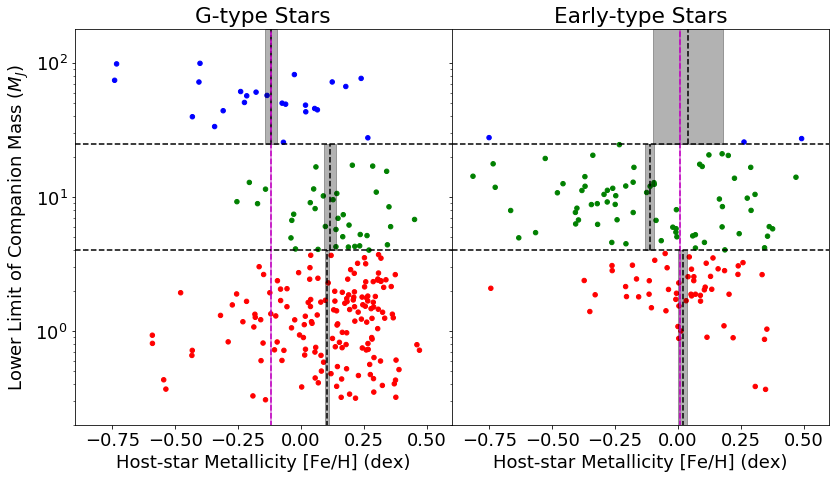

In [49]:
MetalMass(df_pred, Gmm, Gme, Emm, Eme, Gmmc, Gmec, Emmc, Emec).plot()

### Orbital Parameters vs Planet Mass Distribution

In [55]:
class OrbitalMass:
    
    def __init__(self, df, Gam, Gae, Eam, Eae, Gem, Gee, Eem, Eee):
        df['color'] = df['Mp'].apply(lambda x: 'b' if x>=25 else('g' if 4<=x<25 else 'r'))
        self.df = df
        self.G = df[(df['Ms']>=0.8)&(df['Ms']<1.3)]
        self.E = df[df['Ms']>=1.3]
        self.Gam = np.array(Gam)
        self.Gae = np.array(Gae)
        self.Eam = np.array(Eam)
        self.Eae = np.array(Eae)
        self.Gem = np.array(Gem)
        self.Gee = np.array(Gee)
        self.Eem = np.array(Eem)
        self.Eee = np.array(Eee)
    
    def _fill(self, m, e):
        left = m-e
        right = m+e
        range1 = [[left[0], left[0], right[0], right[0]], [180, 25, 25, 180]]
        range2 = [[left[1], left[1], right[1], right[1]], [25, 4, 4, 25]]
        range3 = [[left[2], left[2], right[2], right[2]], [4, 0.1, 0.1, 4]]
        return [range1, range2, range3]
    
    def _subplot(self, ax, x, y, c, mean, xmin, xmax, fill):
        ax.scatter(x, y, c=c, s=20)
        ax.vlines(mean[0], 25, 180, color='k', linestyle='dashed')
        ax.vlines(mean[1], 4, 25, color='k', linestyle='dashed')
        ax.vlines(mean[2], 0.1, 4, color='k', linestyle='dashed')
        ax.hlines(25, xmin, xmax, color='k', linestyle='dashed')
        ax.hlines(4, xmin, xmax, color='k', linestyle='dashed')
        ax.fill(fill[0][0], fill[0][1], c='k', alpha=0.3)
        ax.fill(fill[1][0], fill[1][1], c='k', alpha=0.3)
        ax.fill(fill[2][0], fill[2][1], c='k', alpha=0.3)
    
    def plot(self):
        Gax = self.G['a']
        Eax = self.E['a']
        Gex = self.G['e']
        Eex = self.E['e']
        Gy = self.G['Mp']
        Ey = self.E['Mp']
        rangeGa = self._fill(self.Gam, self.Gae)
        rangeEa = self._fill(self.Eam, self.Eae)
        rangeGe = self._fill(self.Gem, self.Gee)
        rangeEe = self._fill(self.Eem, self.Eee)
        fig = plt.figure(figsize=(11, 11))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222, sharey=ax1)
        ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1)
        ax4 = fig.add_subplot(224, sharex=ax2, sharey=ax1)
        self._subplot(ax1, Gax, Gy, self.G['color'], self.Gam, 0.01, 10, rangeGa)
        self._subplot(ax2, Gex, Gy, self.G['color'], self.Gem, -0.05, 1.05, rangeGe)
        self._subplot(ax3, Eax, Ey, self.E['color'], self.Eam, 0.01, 10, rangeEa)
        self._subplot(ax4, Eex, Ey, self.E['color'], self.Eem, -0.05, 1.05, rangeEe)
        ax2.text(-0.27, 110, 'G-type Stars', fontsize=22, bbox=dict(facecolor='gold'))
        ax4.text(-0.32, 110, 'Early-type Stars', fontsize=22, bbox=dict(facecolor='gold'))
        ax1.loglog()
        ax3.set_xlabel('Semi-Major Axis (au)')
        ax4.set_xlabel('Eccentricity')
        ax1.set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        ax3.set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        ax1.set_xlim(0.01, 9)
        ax2.set_xlim(-0.05, 1.05)
        ax1.set_ylim(0.2, 180)
        ax1.tick_params(labelbottom=False)
        ax2.tick_params(labelbottom=False, labelleft=False)
        ax4.tick_params(labelleft=False)
        fig.tight_layout()
        fig.subplots_adjust(hspace=0, wspace=0)
        #fig.savefig(f'{directory}/Manuscript/Draft/orbit_Mp_sep.pdf')
        fig.show()

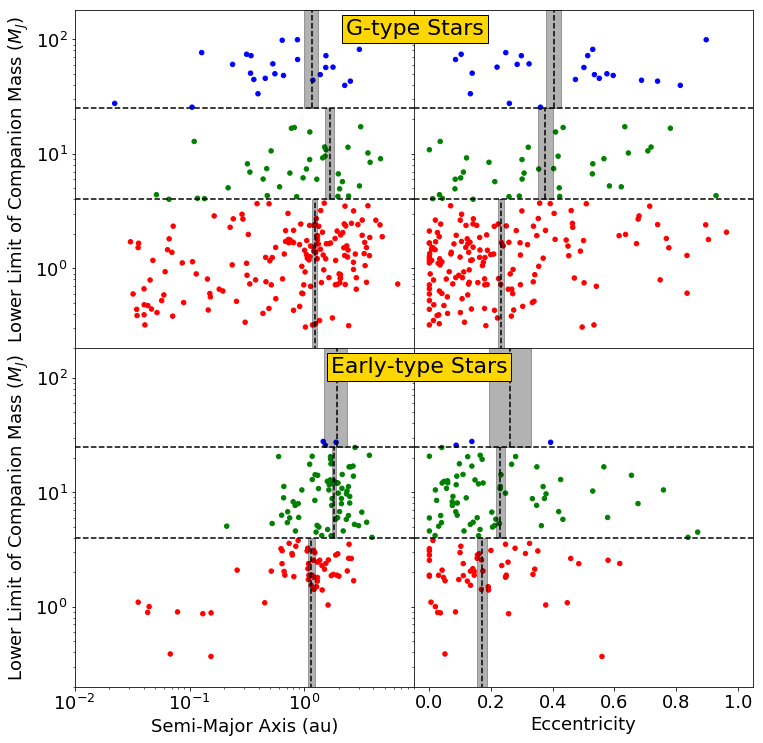

In [54]:
OrbitalMass(df_pred, Gam, Gae, Eam, Eae, Gem, Gee, Eem, Eee).plot()

# Discussion

## Planetary Formation Process around G- and Early-type Stars

In [56]:
class Discussion:

    def __init__(self, df_obs=None, border=None):
        df = pd.read_csv(f'{directory}/Data/Mordasini.csv')
        df['Mp'] = df['M [Mearth]']/317.8*(np.pi/4)
        df = df.rename(columns={'af [AU]': 'a', '[Fe/H]': 'Fe/H'})
        df = df.drop(columns=['[M_D/M_SN]', 'astart [AU]', 'M [Mearth]'])
        df = df[df['Mp']>=0.1]
        self.df = df
        self.df_obs = df_obs[['Fe/H', 'a_lim', 'Mp_lim']]
        self.border = border
        self.df_select = self._selection()
        self.df_rich = self.df_select[self.df_select['Fe/H']>=border]
        self.df_poor = self.df_select[self.df_select['Fe/H']<border]
        
    def _selection(self):
        df_select = self.df
        df_select = self._judgement(df_select, 'rich')
        df_select = self._judgement(df_select, 'poor')
        return df_select
        
    def _judgement(self, df_select, metal):
        n = len(df_select)
        if metal=='rich':
            df_tar = self.df_obs[self.df_obs['Fe/H']>=self.border]
        elif metal=='poor':
            df_tar = self.df_obs[self.df_obs['Fe/H']<self.border]
        df_lim = df_tar.sample(n=n, replace=True).drop(columns=['Fe/H']).reset_index(drop=True)
        df_merge = df_select.join(df_lim)
        a_tar = df_merge['a']
        Mp_tar = df_merge['Mp']
        a_lim = df_merge['a_lim']
        Mp_lim = df_merge['Mp_lim']
        df_judge = df_merge[(a_tar/a_lim<=(Mp_tar/Mp_lim)**2)&(a_tar/a_lim<=1)][['Fe/H', 'a', 'Mp']]        
        return df_judge
        
    def plot(self):
        x_rich = self.df_rich['a']
        x_poor = self.df_poor['a']
        y_rich = self.df_rich['Mp']
        y_poor = self.df_poor['Mp']
        plt.rcParams['font.size'] = 18
        fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
        axes[0].loglog()
        axes[0].scatter(x_rich, y_rich, s=7)
        axes[0].set_xlabel('Semi-Major Axis [au]')
        axes[0].set_ylabel('Lower Limit of Companion Mass ($M_{J}$)')
        axes[1].loglog()
        axes[1].scatter(x_poor, y_poor, s=7)
        axes[1].set_xlabel('Semi-Major Axis [au]')
        fig.tight_layout()
        fig.subplots_adjust(wspace=0)
        fig.show()

In [57]:
class SimulationComparison:
    
    def __init__(self, df, metal_bord=0.17):
        df = df[df['Mp']<=25]
        self._df = df
        self._df_high = df[df['Ms']>=1.3]
        self._df_low = df[(df['Ms']>=0.8)&(df['Ms']<1.3)]
        self._df_high_rich = self._df_high[self._df_high['Fe/H']>=metal_bord]
        self._df_high_poor = self._df_high[self._df_high['Fe/H']<metal_bord]
        self._df_low_rich = self._df_low[self._df_low['Fe/H']>=metal_bord]
        self._df_low_poor = self._df_low[self._df_low['Fe/H']<metal_bord]
        dis = Discussion(df_obs=df_tar[(df_tar['Ms']>=0.8)&(df_tar['Ms']<1.3)], border=metal_bord)
        self.sim = dis.df_select[dis.df_select['Mp']<=25]
        
    def _bin_average(self, df):
        dm = 0.26
        ms = -0.8
        pm = []
        pe = []
        for _ in range(5):
            me = ms+dm
            p = df[(df['Fe/H']>=ms)&(df['Fe/H']<me)]['Mp']
            if len(p)==0:
                pm.append(0)
                pe.append(0)
            else:
                pm.append(p.mean())
                pe.append(p.std()/len(p)**0.5)
            ms = me
        return pm, pe
        
    def plot(self):
        bins = 10**np.linspace(-1, 1.2, 100)
        MpG = self._df_low['Mp'].values
        MpE = self._df_high['Mp'].values
        MpS = self.sim['Mp'].values
        metal = np.linspace(-0.67, 0.37, 5)
        Mphm, Mphe = self._bin_average(self._df_high)
        Mplm, Mple = self._bin_average(self._df_low)
        Mpsm, Mpse = self._bin_average(self.sim)
        fig = plt.figure(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.hist(MpG, bins=100, cumulative=True, normed=True, alpha=0.9, color='c')
        ax1.hist(MpS, bins=100, cumulative=True, normed=True, alpha=0.9, color='m')
        ax1.hist(MpE, bins=100, cumulative=True, normed=True, alpha=0.9, color='y')
        ax1.vlines(4, 0, 1.5, color='k', linestyle='dashed' )
        ax1.set_xlabel('Lower Limit of Companion Mass ($M_J$)')
        ax1.set_ylabel('Cumurative Fraction')
        ax1.set_xlim(-1, 21)
        ax1.set_ylim(0, 1.05)
        ax2.bar(metal-0.07, Mplm, yerr=Mple, width=0.07, color='c', label='G-type Stars')
        ax2.bar(metal, Mphm, yerr=Mphe, width=0.07, color='y', label='Early-type Stars')
        ax2.bar(metal+0.07, Mpsm, yerr=Mpse, width=0.07, color='m', label='Simulation data')
        #ax2.legend(loc='upper right')
        ax2.set_xlabel('Host-star Metallicity [Fe/H] (dex)')
        ax2.set_ylabel('Lower Limit of Companion Mass ($M_J$)')
        fig.tight_layout()
        #fig.savefig('/Users/shohei/Desktop/Shohei/IRAL/MasterThesis/Figure(Formation)/simulation.pdf')
        #fig.savefig(f'{directory}/Manuscript/Draft/simulation.pdf')
        fig.show()

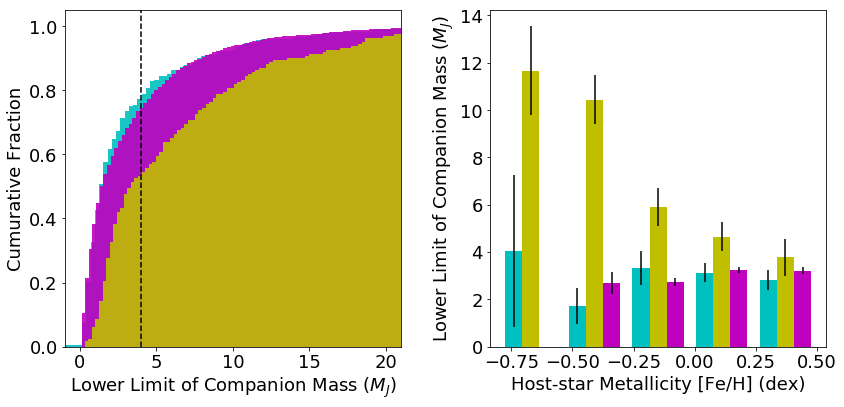

In [195]:
SimulationComparison(df_pred, metal_bord=0.17).plot()

## Planetary Formation Scenarios

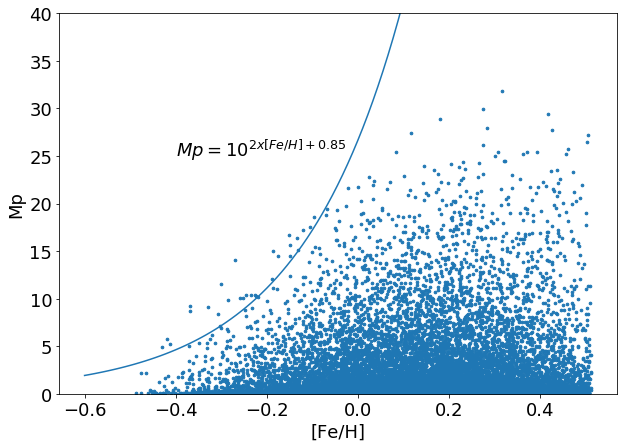

In [202]:
# シミュレーションから漸近線の近似式を求める
a = 1.9
b = 0.75
df_mordasini = pd.read_csv(f'{directory}/Data/Mordasini.csv')
df_mordasini['Mp'] = df_mordasini['M [Mearth]']/317.8*(np.pi/4)
df_mordasini.plot(x='[Fe/H]', y='Mp', kind='scatter', s=7, figsize=(10, 7))
x = np.linspace(-0.6, 0.5, 100)
f = 10**(a*(x+b))
plt.plot(x, f)
plt.text(-0.4, 25, '$Mp=10^{2x[Fe/H]+0.85}$')
plt.ylim(0, 40)
plt.show()

In [21]:
class PlanetaryFormation:
    
    def __init__(self, df, metal_border=-0.07, mass_border=[4, 25], a=0, b=0):
        self._df = df
        self._a = a
        self._b = b
        
    def _core_accretion(self):
        return [[-0.9, -0.9, 0.6, 0.6, np.log10(30)/self._a-self._b], [10**(self._a*(-0.9)+self._b), 0.1, 0.1, 30, 30]]
        
    def _disk_instability(self):
        return [[-0.9, -0.9, 0.6, 0.6], [30, 4, 4, 30]]
    
    def _binary(self):
        return [[-0.9, -0.9, 0.6, 0.6], [200, 20, 20, 200]]
        
    def plot(self):
        HR8799_metal = [-0.47, -0.47, -0.47, -0.47]
        HR8799_Mp = [10, 7, 10, 9]
        HR8799_dMp = [3, 3, 3, 4]
        df_high = self._df[self._df['Ms']>=1.3]
        df_low = self._df[(self._df['Ms']>=0.8)&(self._df['Ms']<1.3)]
        xh = df_high['Fe/H']
        yh = df_high['Mp']
        xhe = df_high['dFe/H']
        yhe = df_high['dMp']
        xl = df_low['Fe/H']
        yl = df_low['Mp']
        xle = df_low['dFe/H']
        yle = df_low['dMp']
        region1 = self._core_accretion()
        region2 = self._disk_instability()
        region3 = self._binary()
        fig = plt.figure(figsize=(12, 7))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
        ax1.set_yscale('log')
        ax1.scatter(xl, yl, c='k', s=20)
        ax1.errorbar(xl, yl, xerr=xle, yerr=yle, fmt='o', ms=0, ecolor='k', elinewidth=1, capsize=4, capthick=1, zorder=1)
        ax1.fill(region1[0], region1[1], c='r', alpha=0.3)
        ax1.fill(region2[0], region2[1], c='g', alpha=0.1)
        ax1.fill(region3[0], region3[1], c='b', alpha=0.3)
        ax1.set_title('G-type Stars')
        ax1.set_xlabel('Host-star Metallicity [Fe/H] (dex)')
        ax1.set_ylabel('Lower Limit of Companion Mass ($M_{J}$)')
        ax1.set_xlim(-0.9, 0.58)
        ax1.set_ylim(0.2, 180)
        ax1.text(-0.85, 1.3, 'Core accretion', fontsize=18, color='r')
        ax1.text(-0.85, 15, 'Disk instability', fontsize=18, color='g')
        ax1.text(-0.3, 120, 'Binary star formation', fontsize=18, color='b')
        ax2.scatter(xh, yh, c='k', s=20)
        ax2.errorbar(xh, yh, xerr=xhe, yerr=yhe, fmt='o', ms=0, ecolor='k', elinewidth=1, capsize=4, capthick=1, zorder=1)
        ax2.scatter(HR8799_metal, HR8799_Mp, marker='o', c='m', s=50)
        ax2.errorbar(HR8799_metal, HR8799_Mp, yerr=HR8799_dMp, fmt='o', ms=0, ecolor='m', elinewidth=1, capsize=4, capthick=1, zorder=1)
        ax2.fill(region1[0], region1[1], c='r', alpha=0.3)
        ax2.fill(region2[0], region2[1], c='g', alpha=0.3)
        ax2.fill(region3[0], region3[1], c='b', alpha=0.3)
        ax2.set_title('Early-type Stars')
        ax2.set_xlabel('Host-star Metallicity [Fe/H] (dex)')
        ax2.tick_params(labelleft=False)
        ax2.text(-0.6, 0.5, 'Core accretion', fontsize=18, color='r')
        ax2.text(-0.88, 3.5, 'Disk instability', fontsize=18, color='g')
        ax2.text(-0.7, 120, 'Binary star formation', fontsize=18, color='b')
        fig.tight_layout()
        fig.subplots_adjust(wspace=0)
        #fig.savefig(f'{directory}/Manuscript/Draft/formation.pdf')
        #fig.savefig(f'{directory}/Figure/formation_no.pdf')
        fig.show()

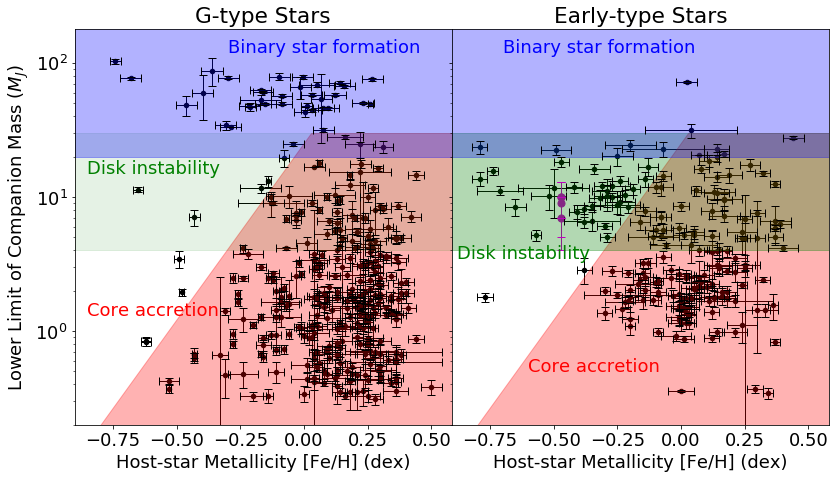

In [22]:
PlanetaryFormation(df_tar, a=1.9, b=0.75).plot()

## Metallicity vs Eccentricity divided into G-type and Early-type Stars

In [27]:
class MetalEccentricity:
    
    def __init__(self, df):
        self.df = df
        self.G = df[(df['Ms']>=0.8)&(df['Ms']<1.3)]
        self.E = df[df['Ms']>=1.3]
        self.Gi = self.G[self.G['Mp']<4]
        self.Gm = self.G[(self.G['Mp']>=4)&(self.G['Mp']<25)]
        self.Ei = self.E[self.E['Mp']<4]
        self.Em = self.E[(self.E['Mp']>=4)&(self.E['Mp']<25)]
        
    def _core_accretion(self, xmin):
        return [[xmin, xmin, 0.6, 0.6], [1.2, -0.1, -0.1, 1.2]]
        
    def _disk_instability(self, ymax):
        return [[-0.9, -0.9, 0.6, 0.6], [ymax, -0.1, -0.1, ymax]]
        
    def _subplot(self, df, ax, CA=None, DI=None, alpha_CA=0.3, alpha_DI=0.3, text_CA=False, text_DI=False, xlabel=True, ylabel=True):
        x = df['Fe/H']
        xerr = df['dFe/H']
        y = df['e']
        yerr = df['de']
        ax.scatter(x, y, s=20, c='k')
        ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=0, ecolor='k', elinewidth=1, capsize=4, capthick=1, zorder=1)
        if CA:
            region_CA = self._core_accretion(CA)
            ax.fill(region_CA[0], region_CA[1], c='r', alpha=alpha_CA)
        if DI:
            region_DI = self._disk_instability(DI)
            ax.fill(region_DI[0], region_DI[1], c='g', alpha=alpha_DI)
        if text_CA: ax.text(-0.74, 0.9, 'Core accretion', fontsize=18, color='r')
        if text_DI: ax.text(-0.85, 0.0, 'Disk instability', fontsize=18, color='g')
        if xlabel: ax.set_xlabel('Metallicity [Fe/H] (dex)')
        if ylabel: ax.set_ylabel('Eccentricity')
        ax.set_xlim(-0.9, 0.58)
        ax.set_ylim(-0.05, 1.05)
        
    def plot(self, save=True):
        HR8799_metal = [-0.47, -0.47, -0.47, -0.47]
        HR8799_e = [0.018, 0.022, 0.129, 0.118]
        HR8799_de = [0.0155, 0.02, 0.0235, 0.0235]
        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)
        ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1)
        ax4 = fig.add_subplot(224, sharex=ax1, sharey=ax1)
        self._subplot(self.Gi, ax1, CA=-0.75, text_CA=True, xlabel=False)
        self._subplot(self.Ei, ax2, CA=-0.75, xlabel=False, ylabel=False)
        self._subplot(self.Gm, ax3, CA=-0.3, DI=0.35, alpha_DI=0.1, text_DI=True)
        self._subplot(self.Em, ax4, CA=-0.3, DI=0.35, ylabel=False)
        ax2.text(-1.45, 0.97, 'Intermediate-mass Planets', fontsize=18, bbox=dict(facecolor='gold'))
        ax4.text(-1.24, 0.97, 'Massive Planets', fontsize=18, bbox=dict(facecolor='gold'))
        ax4.scatter(HR8799_metal, HR8799_e, marker='o', c='m', s=50)
        ax4.errorbar(HR8799_metal, HR8799_e, yerr=HR8799_de, fmt='o', ms=0, ecolor='m', elinewidth=1, capsize=4, capthick=1, zorder=1)
        ax1.set_title('G-type Stars')
        ax2.set_title('Early-type Stars')
        ax1.tick_params(labelbottom=False)
        ax2.tick_params(labelbottom=False, labelleft=False)
        ax4.tick_params(labelleft=False)
        fig.tight_layout()
        fig.subplots_adjust(hspace=0, wspace=0)
        if save:
            fig.savefig(f'{directory}/Manuscript/Draft/metal_e_sep.pdf')
            #fig.savefig(f'{directory}/Figure/meatl_e_sep_no.pdf')
        fig.show()

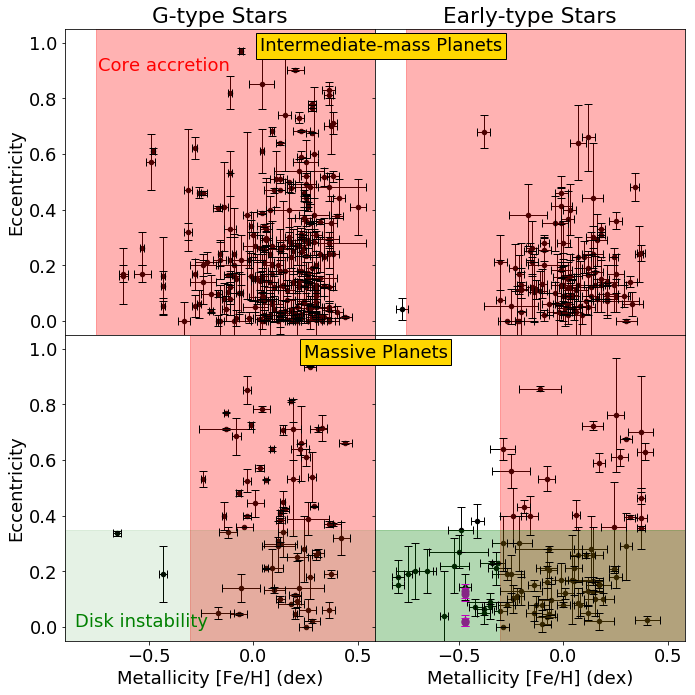

In [182]:
MetalEccentricity(df_tar).plot(save=True)

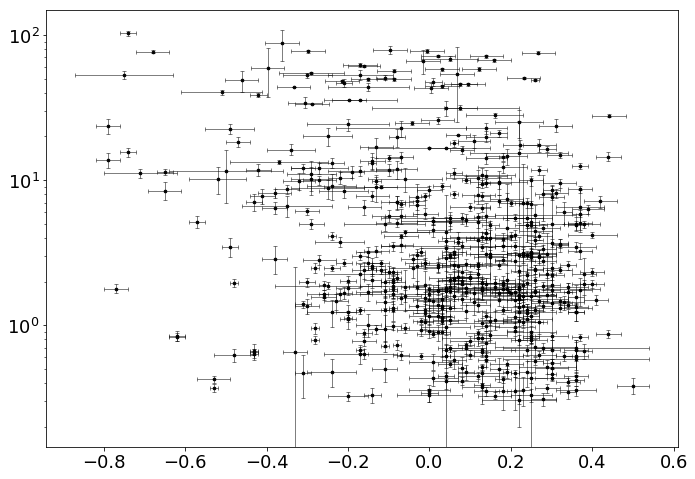

In [36]:
plt.figure(figsize=(10, 7))
plt.scatter(df_tar['Fe/H'], df_tar['Mp'], s=7, c='k')
plt.errorbar(df_tar['Fe/H'], df_tar['Mp'], xerr=df_tar['dFe/H'], yerr=df_tar['dMp'], fmt='o', ms=0, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, zorder=1)
plt.yscale('log')
plt.tight_layout()
plt.savefig(f'{directory}/Figure/metal_Mp.png')
plt.show()

# Appendix

In [78]:
class Table:
    
    def __init__(self):
        # データの読み出し
        directory = '/Users/shohei/Desktop/Shohei/Fresnel/Formation'
        file_name = f'{directory}/Data/dataset_new.xlsx'
        sheet_name = '2019-01-30'
        excel_book = pd.ExcelFile(file_name)
        df_raw = excel_book.parse(sheet_name)
        df = self._select(df_raw)
        df = self._round(df)
        df = self._revise(df)
        df = self._command(df)
        self.df = df
        
    def _select(self, df):
        # 使うデータを選択
        main_cols = ['planet parameters']
        df = df.dropna(subset=main_cols)
        df = df[df['Mp']>=0.3]
        return df
    
    def _round(self, df):
        # データの桁数を整理
        col_1 = ['Term']
        col_2 = ['Fe/H', 'dFe/H', 'Ms', 'dMs', 'a', 'da', 'Mp', 'dMp', 'K', 'dK', 'P', 'dP', 'RMS']
        col_3 = ['e', 'de']
        df[col_1] = df[col_1].round(1)
        df[col_2] = df[col_2].round(2)
        df[col_3] = df[col_3].round(3)
        return df

    def _revise(self, df):
        # 主星名と惑星名のカラムを修正
        df[['star1', 'star2', 'star3']] = df['star'].str.split(' ', expand=True)
        df[['planet1', 'planet2', 'planet3', 'planet4']] = df['planet'].str.split(' ', expand=True)
        return df
    
    def _command(self, df):
        # Texのコマンド用のカラムを作成
        df['Fe/H_all'] = self._with_error(df, 'Fe/H', 'dFe/H')
        df['Ms_all'] = self._with_error(df, 'Ms', 'dMs')
        df['a_all'] = self._with_error(df, 'a', 'da')
        df['Mp_all'] = self._with_error(df, 'Mp', 'dMp')
        df['K_all'] = self._with_error(df, 'K', 'dK')
        df['P_all'] = self._with_error(df, 'P', 'dP')
        df['e_all'] = self._with_error(df, 'e', 'de')
        df = self._calibrated(df, 'Fe/H_all', 'Fe/H_sweet', 'Fe/H_casa')
        df = self._calibrated(df, 'Ms_all', 'Ms_sweet', 'Ms_padova')
        df['ref_star'] = self._reference(df, 'accuracy reference')
        df['ref_planet'] = self._reference(df, 'planet parameters')
        df['&'] = '&'
        df['\\\\'] = '\\\\'
        return df
    
    def _with_error(self, df, param, param_err):
        # _command関数で使用
        df = df.fillna('-')
        _df = pd.DataFrame(index=df.index)
        values = []
        for value, err in zip(df[param], df[param_err]):
            if not value=='-':
                values.append(f'{value}'+'$\pm$'+f'{err}')
            else:
                values.append(r'\tablenotemark{2}-')
        return values
        
    def _calibrated(self, df, param, param1, param2):
        df.loc[(df[param1].isnull())&(~df[param2].isnull()), param] = df[(df[param1].isnull())&(~df[param2].isnull())][param].apply(lambda x: r'\tablenotemark{a}'+f'{x}')
        return df
    
    def _reference(self, df, param):
        # _command関数で使用
        df = df.fillna('-')
        _df = pd.DataFrame(index=df.index)
        references = []
        for ref in df[param]:
            if not ref=='-':
                references.append(r'{\cite{'+f'{ref}'+'}}')
            else:
                references.append('-')
        return references
    
    def star(self, df):
        # 主星パラメータのDFを作成
        df = df.groupby('star').max()
        df[['RMS', 'Term']] = df[['RMS', 'Term']].fillna(r'\tablenotemark{b}-')
        df = df[['star1', 'star2', 'star3', '&', 'Fe/H_all', '&', 'Ms_all', '&', 'RMS', '&', 'Term', '&',
                 'ref_star', '\\\\']]
        return df
    
    def planet(self, df):
        # 惑星パラメータのDFを作成
        df = df.sort_values('planet')
        df = df[['planet1', 'planet2', 'planet3', 'planet4', '&', 'a_all', '&', 'Mp_all', '&',
                 'K_all', '&', 'P_all', '&', 'e_all', '&', 'ref_planet', '\\\\']]
        return df
    
    def save(self, df, target):
        # テキストファイルとして保存
        df.to_csv(f'{directory}/Data/table_{target}.txt', sep=' ', index=None, header=None)

## Host-star Character

In [184]:
# 主星パラメータの表を作成
def main():
    tab = Table()
    df = tab.df
    df_star = tab.star(df)
    tab.save(df_star, 'star')
    return df_star
main()

,star1,star2,star3,&,Fe/H_all,&,Ms_all,&,RMS,&,Term,&,ref_star,\\
star,,,,,,,,,,,,,,
11 Com,11,Com,NaN,&,-0.34$\pm$0.06,&,2.14$\pm$0.28,&,25.5,&,3.1,&,{\cite{2008ApJ...672..553L}},\\
11 UMi,11,UMi,NaN,&,-0.13$\pm$0.04,&,3.4$\pm$0.76,&,27.5,&,3.5,&,{\cite{2009A&A...505.1311D}},\\
14 And,14,And,NaN,&,-0.29$\pm$0.03,&,2.38$\pm$0.29,&,20.3,&,4.1,&,{\cite{2008PASJ...60.1317S}},\\
14 Her,14,Her,NaN,&,0.38$\pm$0.04,&,0.99$\pm$0.09,&,13,&,7.1,&,{\cite{2007ApJ...654..625W}},\\
15 Sagittae,15,Sagittae,NaN,&,0.05$\pm$0.07,&,1.08$\pm$0.04,&,\tablenotemark{b}-,&,\tablenotemark{b}-,&,{\cite{2012ApJ...751...97C}},\\
16 Cyg B,16,Cyg,B,&,0.09$\pm$0.01,&,1.01$\pm$0.08,&,7.3,&,16,&,{\cite{2006ApJ...646..505B}},\\
18 Del,18,Del,NaN,&,0.0$\pm$0.03,&,1.76$\pm$0.18,&,15.4,&,4.8,&,{\cite{2008PASJ...60..539S}},\\
24 Boo,24,Boo,NaN,&,-0.77$\pm$0.03,&,2.72$\pm$0.21,&,26.51,&,13.2,&,{\cite{2018PASJ...70...59T}},\\
24 Sex,24,Sex,NaN,&,-0.01$\pm$0.05,&,1.4$\pm$0.16,&,5,&,5.2,&,{\cite{2011AJ....141...16J}},\\


## Planet Character

In [80]:
# 惑星パラメータの表を作成
def main():
    tab = Table()
    df = tab.df
    df_planet = tab.planet(df)
    tab.save(df_planet, 'planet')
    return df_planet
main()

,planet1,planet2,planet3,planet4,&,a_all,&,Mp_all,&,K_all,&,P_all,&,e_all,&,ref_planet,\\
120,11,Com,b,None,&,1.2$\pm$0.05,&,16.23$\pm$1.45,&,296.7$\pm$5.6,&,326.03$\pm$0.32,&,0.231$\pm$0.005,&,{\cite{2008ApJ...672..553L}},\\
144,11,UMi,b,None,&,1.89$\pm$0.14,&,16.87$\pm$2.59,&,189.7$\pm$7.15,&,516.22$\pm$3.25,&,0.08$\pm$0.03,&,{\cite{2009A&A...505.1311D}},\\
127,14,And,b,None,&,0.85$\pm$0.03,&,5.0$\pm$0.41,&,100$\pm$1.3,&,185.84$\pm$0.23,&,0.0$\pm$0.0,&,{\cite{2008PASJ...60.1317S}},\\
106,14,Her,b,None,&,2.86$\pm$0.09,&,4.95$\pm$0.3,&,90$\pm$0.5,&,1773.4$\pm$2.5,&,0.369$\pm$0.005,&,{\cite{2007ApJ...654..625W}},\\
362,15,Sagittae,b,None,&,0.35$\pm$0.01,&,68.7$\pm$2.75,&,\tablenotemark{2}-,&,73.3$\pm$3.05,&,0.5$\pm$0.01,&,{\cite{2012ApJ...751...97C}},\\
52,16,Cyg,B,b,&,1.69$\pm$0.04,&,1.7$\pm$0.11,&,50.5$\pm$1.6,&,798.5$\pm$1.0,&,0.681$\pm$0.017,&,{\cite{2006ApJ...646..505B}},\\
122,18,Del,b,None,&,2.35$\pm$0.08,&,8.52$\pm$0.59,&,119.4$\pm$1.3,&,993.3$\pm$3.2,&,0.08$\pm$0.01,&,{\cite{2008PASJ...60..539S}},\\
608,24,Boo,b,None,&,0.27$\pm$0.01,&,1.79$\pm$0.13,&,59.9$\pm$3.25,&,30.35$\pm$0.01,&,0.042$\pm$0.038,&,{\cite{2018PASJ...70...59T}},\\
291,24,Sex,b,None,&,1.3$\pm$0.05,&,1.55$\pm$0.14,&,33.2$\pm$1.6,&,455.2$\pm$3.2,&,0.184$\pm$0.029,&,{\cite{2011AJ....141...16J}},\\
292,24,Sex,c,None,&,2.06$\pm$0.08,&,1.28$\pm$0.19,&,23.5$\pm$2.9,&,910.0$\pm$21.0,&,0.412$\pm$0.064,&,{\cite{2011AJ....141...16J}},\\


# Others

In [ ]:
def matsuo():
    _df = df_raw.dropna(subset=drop_cols)
    _df = _df[_df['Mp']>=0.1]
    _df_l = _df[(_df['Ms']>=0.8)&(_df['Ms']<1.3)]
    _df_h = _df[_df['Ms']>=1.3]
    N_all = len(_df)
    N_sweet = len(_df.dropna(subset=['Fe/H_sweet']))
    N_change = N_all-N_sweet
    Nl_all = len(_df_l)
    Nl_sweet = len(_df_l.dropna(subset=['Fe/H_sweet']))
    Nl_change = Nl_all-Nl_sweet
    Nh_all = len(_df_h)
    Nh_sweet = len(_df_h.dropna(subset=['Fe/H_sweet']))
    Nh_change = Nh_all-Nh_sweet
    print(N_all, Nl_all, Nh_all)
    print(N_change, Nl_change, Nh_change)

matsuo()

In [87]:
class Schlaufman:
    
    def __init__(self):
        self.df1 = pd.read_csv('/Users/shohei/Desktop/Shohei/Fresnel/Formation/Data/schlaufman_1.txt', sep='\t')
        self.df2 = pd.read_csv('/Users/shohei/Desktop/Shohei/Fresnel/Formation/Data/schlaufman_2.txt', sep='\t')
        self.df1 = self._split(self.df1)
        self.df2 = self._split(self.df2)
        
    def _split(self, df):
        df = df['Mass'].str.split('$|{|}', expand=True)[[1, 3, 5]].astype(float)
        df.columns = ['Mp', 'uMp', 'lMp']
        return df